In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import (
    Audio,
    display,
    clear_output
)
from ipywidgets import widgets
from functools import partial
import scipy.signal as signal
import splane
%matplotlib inline

In [2]:
# Constantes utiles
PI_2      = 2 * np.pi
w_start   = 10.0 * PI_2
w_stop    = 20.0e3 * PI_2
f_s       = 16.0e3
w_s       = f_s * PI_2
duracion  = 0.5
duracion_2s = 2.0

notas_str = ['si', 'la', 'sol', 'fa', 'mi', 're', 'do']

In [3]:
# Vector de tiempo
t = np.linspace(0., duracion, int(f_s * duracion))
t_2s = np.linspace(0., duracion_2s, int(f_s * duracion_2s))

In [4]:
# Player
def player(x, t, fs):
    display(Audio(x, rate=fs, autoplay=False))

In [5]:
# Frecuencias centrales analogicas
f_notas_analogicas = [
    493.883, # SI_3
    440.000, # LA_3
    391.995, # SOL_3
    349.228, # FA_3
    329.628, # MI_3
    293.665, # RE_3
    261.626] # DO_3
w_notas_analogicas = PI_2 * np.array(f_notas_analogicas)

In [6]:
# Retorna un seno de frecuencia f sampleado en los momentos t
def create_sin(f, t):
    return np.sin(PI_2 * f * t)

In [7]:
# Computo los audios de cada nota
notas = [create_sin(f, t) for f in f_notas_analogicas]

In [8]:
# Probamos las notas
for i in range(0, len(notas)):
    print('{}: f={}Hz'.format(notas_str[i], f_notas_analogicas[i]))
    player(notas[i], t, f_s)

si: f=493.883Hz


la: f=440.0Hz


sol: f=391.995Hz


fa: f=349.228Hz


mi: f=329.628Hz


re: f=293.665Hz


do: f=261.626Hz


In [9]:
N = 3 # Orden del filtro pasa bajos.
Q = 10 # Q del nucleo de transformacion.
f0 = f_notas_analogicas[1] # LA - cambiar para sintonizar en otra nota.

In [10]:
# Filtro pasabajos prototipo analogicos
z_lp_proto_analog, p_lp_proto, k_lp_proto = signal.buttap(N)

In [11]:
# Sintonizo el filtro en LA
wo = PI_2*f0
bw = wo / Q
z_bp_analog, p_bp_analog, k_bp_analog = signal.lp2bp_zpk(z_lp_proto_analog, p_lp_proto, k_lp_proto, wo=wo, bw=bw)

num_analog, den_analog = signal.zpk2tf(z_bp_analog, p_bp_analog, k_bp_analog)
filtro_analog = signal.TransferFunction(num_analog, den_analog)

In [12]:
filtro_analog

TransferFunctionContinuous(
array([21129909.38187728,        0.        ,        0.        ,
              0.        ]),
array([1.00000000e+00, 5.52920307e+02, 2.30819254e+07, 8.47309366e+09,
       1.76415655e+14, 3.22992710e+16, 4.46473070e+20]),
dt: None
)

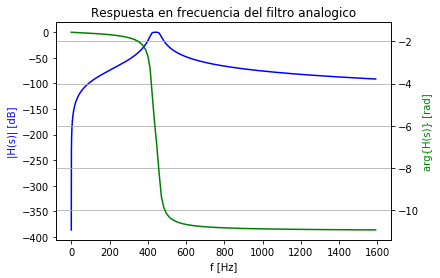

In [13]:
# Hago un plot de la respuesta en frecuencia (en s!)
w, h_s = signal.freqs(num_analog, den_analog, worN=512)
ff = (1. / PI_2) * np.array(w)

fig, ax1 = plt.subplots()
ax1.set_title('Respuesta en frecuencia del filtro analogico')
ax1.plot(ff, 20 * np.log10(abs(h_s)), 'b')
ax1.set_ylabel('|H(s)| [dB]', color='b')
ax1.set_xlabel('f [Hz]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h_s))
ax2.plot(ff, angles, 'g')
ax2.set_ylabel('arg{H(s)} [rad]', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

In [14]:
# Lo convierto a digital! (sin prewarping...)
num_digital, den_digital = signal.bilinear(num_analog, den_analog, fs=f_s)

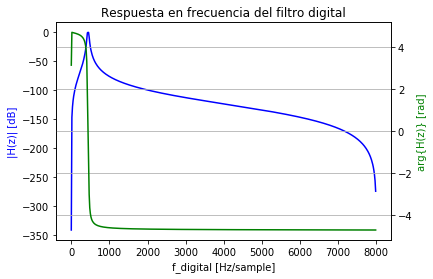

In [15]:
# Hago un plot de la respuesta en frecuencia (en z!)
w, h_z = signal.freqz(num_digital, den_digital, worN=512, fs=f_s)

fig, ax1 = plt.subplots()
ax1.set_title('Respuesta en frecuencia del filtro digital')
ax1.plot(w, 20 * np.log10(abs(h_z)), 'b')
ax1.set_ylabel('|H(z)| [dB]', color='b')
ax1.set_xlabel('f_digital [Hz/sample]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h_z))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('arg{H(z)} [rad]', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

In [16]:
# Filtramos las notas
notas_filtradas = [signal.filtfilt(num_digital, den_digital, nota) for nota in notas]

In [17]:
# Filtramos las notas 
for i in range(0, len(notas)):
    print('{}: f={}Hz'.format(notas_str[i], f_notas_analogicas[i]))
    print('|_ Nota {} sin filtrar'.format(notas_str[i]))
    player(notas[i], t, f_s)
    print('|_ Nota {} filtrada'.format(notas_str[i]))
    player(notas_filtradas[i], t, f_s)
    print('--------------------------------------------------------')

si: f=493.883Hz
|_ Nota si sin filtrar


|_ Nota si filtrada


--------------------------------------------------------
la: f=440.0Hz
|_ Nota la sin filtrar


|_ Nota la filtrada


--------------------------------------------------------
sol: f=391.995Hz
|_ Nota sol sin filtrar


|_ Nota sol filtrada


--------------------------------------------------------
fa: f=349.228Hz
|_ Nota fa sin filtrar


|_ Nota fa filtrada


--------------------------------------------------------
mi: f=329.628Hz
|_ Nota mi sin filtrar


|_ Nota mi filtrada


--------------------------------------------------------
re: f=293.665Hz
|_ Nota re sin filtrar


|_ Nota re filtrada


--------------------------------------------------------
do: f=261.626Hz
|_ Nota do sin filtrar


|_ Nota do filtrada


--------------------------------------------------------


In [18]:
# Creamos una chirp, que varie de f1 a f2 en el periodo t.
def create_chirp(f1, f2, t):
    f = np.linspace(f1, f2, len(t))
    return np.sin(PI_2 * f * t)

In [19]:
# Creo una chirp que vaya del si al do
chirp = create_chirp(f_notas_analogicas[0], f_notas_analogicas[-1], t_2s)
chirp_filtrada = signal.filtfilt(num_digital, den_digital, chirp)

In [20]:
print('Chirp del {} al {}: f={}Hz a f={}Hz'.format(notas_str[0], notas_str[-1], f_notas_analogicas[0], f_notas_analogicas[-1]))
player(chirp, t_2s, f_s)
print('Chirp filtrada del {} al {}: f={}Hz a f={}Hz'.format(notas_str[0], notas_str[-1], f_notas_analogicas[0], f_notas_analogicas[-1]))
player(chirp_filtrada, t_2s, f_s)
print('--------------------------------------------------------')

Chirp del si al do: f=493.883Hz a f=261.626Hz


Chirp filtrada del si al do: f=493.883Hz a f=261.626Hz


--------------------------------------------------------


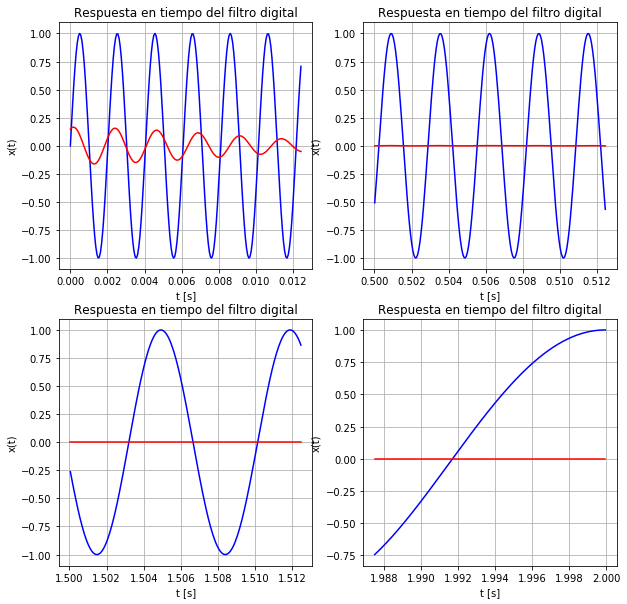

In [21]:
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0][0].set_title('Respuesta en tiempo del filtro digital')
axs[0][0].plot(t_2s[0:200], chirp[0:200], 'b')
axs[0][0].plot(t_2s[0:200], chirp_filtrada[0:200], 'r')
axs[0][0].set_ylabel('x(t)')
axs[0][0].set_xlabel('t [s]')
axs[0][0].grid()
axs[0][0].axis('tight')

x = int(len(t_2s) / 4)
axs[0][1].set_title('Respuesta en tiempo del filtro digital')
axs[0][1].plot(t_2s[x:x+200], chirp[x:x+200], 'b')
axs[0][1].plot(t_2s[x:x+200], chirp_filtrada[x:x+200], 'r')
axs[0][1].set_ylabel('x(t)')
axs[0][1].set_xlabel('t [s]')
axs[0][1].grid()
axs[0][1].axis('tight')

x = int(3 * len(t_2s) / 4)
axs[1][0].set_title('Respuesta en tiempo del filtro digital')
axs[1][0].plot(t_2s[x:x+200], chirp[x:x+200], 'b')
axs[1][0].plot(t_2s[x:x+200], chirp_filtrada[x:x+200], 'r')
axs[1][0].set_ylabel('x(t)')
axs[1][0].set_xlabel('t [s]')
axs[1][0].grid()
axs[1][0].axis('tight')

x = -201
axs[1][1].set_title('Respuesta en tiempo del filtro digital')
axs[1][1].plot(t_2s[x:x+200], chirp[x:x+200], 'b')
axs[1][1].plot(t_2s[x:x+200], chirp_filtrada[x:x+200], 'r')
axs[1][1].set_ylabel('x(t)')
axs[1][1].set_xlabel('t [s]')
axs[1][1].grid()
axs[1][1].axis('tight')

plt.show()

In [22]:
# Ahora, juguemos un poco!
# Sin filtrar...
layout = widgets.Layout(
    width='60px', height='90px',
    border='1px solid black')

output = widgets.Output()
buttons = []

for i in range(0, len(notas)):
    f = notas[i]
    
    button = widgets.Button(
        description=notas_str[i], layout=layout)

    def on_button_clicked(f, b):
        with output:
            clear_output()
            display(Audio(f, rate=f_s, autoplay=True))

    button.on_click(partial(on_button_clicked, f))
    buttons.append(button)

widgets.VBox([widgets.Box(buttons),output])

In [23]:
# Filtradas...
layout = widgets.Layout(
    width='60px', height='90px',
    border='1px solid black')

output = widgets.Output()
buttons = []

for i in range(0, len(notas)):
    f = notas_filtradas[i]
    
    button = widgets.Button(
        description=notas_str[i], layout=layout)

    def on_button_clicked(f, b):
        with output:
            clear_output()
            display(Audio(f, rate=f_s, autoplay=True))

    button.on_click(partial(on_button_clicked, f))
    buttons.append(button)

widgets.VBox([widgets.Box(buttons),output])